Demonstration of Synthetic Data with Latitude and Longitude from a GP with ARD

Training and testing data generated by R script are merged in inferring latent theta.

In [1]:
# LOAD PACKAGES
import warnings
import torch
from gpytorch.distributions import base_distributions
from gpytorch.functions import log_normal_cdf
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
import gpytorch
import time as time

In [2]:
# implement BinomialLikelihood
class BinomialLikelihood(_OneDimensionalLikelihood):
    r"""
    Implements the Binomial likelihood for count data y between 1 and m. 
    The Binomial distribution is parameterized by :math:`m > 0`. 
    We can write the likelihood as:

    .. math::
        \begin{equation*}
            p(Y=y|f,m)=\phi(f)^y(1-\phi(f))^{(m-y)}
        \end{equation*}
    """

    def __init__(self, n_trials):
        super().__init__()
        self.n_trials = n_trials

    def forward(self, function_samples, **kwargs):
        output_probs = base_distributions.Normal(0, 1).cdf(function_samples)
        print(output_probs.size())
        return base_distributions.Binomial(total_count=self.n_trials, probs=output_probs)

    def log_marginal(self, observations, function_dist, *args, **kwargs):
        marginal = self.marginal(function_dist, *args, **kwargs)
        return marginal.log_prob(observations)

    def marginal(self, function_dist, **kwargs):
        mean = function_dist.mean
        var = function_dist.variance
        link = mean.div(torch.sqrt(1 + var))
        output_probs = base_distributions.Normal(0, 1).cdf(link)
        return base_distributions.Binomial(total_count=self.num_data, probs=output_probs)

    def expected_log_prob(self, observations, function_dist, *params, **kwargs):
        if torch.any(torch.logical_or(observations.le(-1), observations.ge(self.n_trials+1))):
            # Remove after 1.0
            warnings.warn(
                "BinomialLikelihood.expected_log_prob expects observations with labels in [0, m]. "
                "Observations <0 or >m are not allowed.",
                DeprecationWarning,
            )
        else:
            for i in range(observations.size(0)):
                observations[i] = torch.clamp(observations[i],0,self.n_trials[i])

        # Custom function here so we can use log_normal_cdf rather than Normal.cdf
        # This is going to be less prone to overflow errors
        log_prob_lambda = lambda function_samples: self.n_trials*log_normal_cdf(-function_samples) + \
                observations.mul(log_normal_cdf(function_samples)-log_normal_cdf(-function_samples))
        log_prob = self.quadrature(log_prob_lambda, function_dist)
        return log_prob


In [3]:
# implement GP class
class BinomialGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = VariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(BinomialGPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.LinearMean(input_size=train_x.size(1))
        # ARD kernel for covariate, geospatial and time confounding
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.size(1)))
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [4]:
def transform_data(data):
    n = data.shape[0]
    x = np.zeros((n,11))
    y = np.zeros((n,))
    theta = np.zeros((n,))
    N = np.zeros((n,))
    x[:,0] = data["latitude"].to_numpy()
    x[:,1] = data["longitude"].to_numpy()
    x[:,2] = (data["gender"].to_numpy()=="Male")
    x[:,3] = (data["gender"].to_numpy()=="Female")
    x[:,4] = (data["gender"].to_numpy()=="Non-binary")
    x[:,5] = (data["race"].to_numpy()=="White")
    x[:,6] = (data["race"].to_numpy()=="Black")
    x[:,7] = (data["race"].to_numpy()=="Hispanic")
    x[:,8] = (data["race"].to_numpy()=="Asian")
    x[:,9] = (data["race"].to_numpy()=="Other")
    x[:,10] = data["year"].to_numpy()
    theta = data["theta"].to_numpy()
    y = data["Y"].to_numpy()
    N = data["n"].to_numpy()

    return torch.from_numpy(x).double(), torch.from_numpy(y).double(),\
            torch.from_numpy(N).double(), theta

In [5]:
torch.manual_seed(0)

# load data
data = pd.read_csv("data.csv", index_col=0)

# transform data
train_x, train_y, train_N, true_theta = transform_data(data)

# initialize likelihood and model
likelihood = BinomialLikelihood(n_trials=train_N)
model = BinomialGPModel(train_x=train_x).double()

training_iterations = 200

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1) 

mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

start = time.time()

for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

end = time.time()

/Users/yahoo/anaconda3/lib/python3.7/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Iter 1/200 - Loss: 124.942
Iter 2/200 - Loss: 248.292
Iter 3/200 - Loss: 90.733
Iter 4/200 - Loss: 94.112
Iter 5/200 - Loss: 118.883
Iter 6/200 - Loss: 104.181
Iter 7/200 - Loss: 74.668
Iter 8/200 - Loss: 53.423
Iter 9/200 - Loss: 46.561
Iter 10/200 - Loss: 49.427
Iter 11/200 - Loss: 54.538
Iter 12/200 - Loss: 57.239
Iter 13/200 - Loss: 56.460
Iter 14/200 - Loss: 53.308
Iter 15/200 - Loss: 49.506
Iter 16/200 - Loss: 46.327
Iter 17/200 - Loss: 44.201
Iter 18/200 - Loss: 42.909
Iter 19/200 - Loss: 42.019
Iter 20/200 - Loss: 41.215
Iter 21/200 - Loss: 40.399
Iter 22/200 - Loss: 39.636
Iter 23/200 - Loss: 39.036
Iter 24/200 - Loss: 38.660
Iter 25/200 - Loss: 38.484
Iter 26/200 - Loss: 38.407
Iter 27/200 - Loss: 38.313
Iter 28/200 - Loss: 38.121
Iter 29/200 - Loss: 37.807
Iter 30/200 - Loss: 37.400
Iter 31/200 - Loss: 36.956
Iter 32/200 - Loss: 36.538
Iter 33/200 - Loss: 36.192
Iter 34/200 - Loss: 35.937
Iter 35/200 - Loss: 35.764
Iter 36/200 - Loss: 35.643
Iter 37/200 - Loss: 35.544
Iter 3

In [6]:
print(model.covar_module.base_kernel.lengthscale)
print(model.covar_module.outputscale)

tensor([[0.3888, 0.1177, 0.3172, 0.3295, 0.2884, 0.2938, 0.3095, 0.3148, 0.2801,
         0.3222, 0.1701]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
tensor(0.2123, dtype=torch.float64, grad_fn=<SoftplusBackward0>)


In [9]:
print("trained for {:d} min {:d} sec for {:d} iterations".format(int(end-start)//60,int(end-start)%60,training_iterations))

trained for 0 min 37 sec for 200 iterations


Text(0, 0.5, 'est theta')

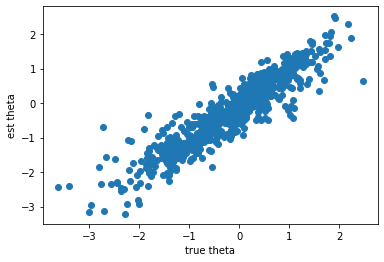

In [10]:
model.eval()
likelihood.eval()

with torch.no_grad():
    f_pred = model(train_x)
    mu = f_pred.mean.numpy()

plt.scatter(true_theta,mu/np.std(mu))
plt.xlabel("true theta")
plt.ylabel("est theta")

In [11]:
results = pd.DataFrame({"true_theta": true_theta, "est_mean": mu/np.std(mu)})
results['est_std'] = np.sqrt(f_pred.variance.numpy())/np.std(mu)
results.to_csv("GPR_result.csv")

lower = results['est_mean'] - 2*results['est_std']
upper = results['est_mean'] + 2*results['est_std']
print("Avg 95% Coverage: {:.3f}".format(np.mean(np.logical_and(lower<=true_theta, upper>=true_theta))))
print("Avg RMSE: {:.3f}".format(np.sqrt(np.mean((true_theta-results['est_mean'])**2))))


Avg 95% Coverage: 0.952
Avg RMSE: 0.412
